In [2]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import transforms
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from src.get_data import *
from src.models import *
from src.utils import cov

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [3]:
# data
sample_size = 2000
batch_size = sample_size // 1
X, X_c, update_mask = get_2d_gaussian(sample_size, device, seed=1)

# implicit PCN

In [4]:
dim = 2
inference_lr = 1e-2 # could be more fine-tuned for each model
training_lr = 1e-4 # could be more fine-tuned for each model
training_iters = 100
inference_iters = 100
imPCN = RecPCN(dim, dendrite=True).to(device)
optimizer_im = torch.optim.SGD(imPCN.parameters(), lr=training_lr)

train_mses_im = []
for i in range(training_iters):
    if i % 10 == 0:
        print('Epoch', i)
    for batch_idx in range(0, sample_size, batch_size):
        data = X[batch_idx:batch_idx+batch_size]
        optimizer_im.zero_grad()
        imPCN.learning(data)
        optimizer_im.step()
    train_mses_im.append(imPCN.train_mse.cpu().detach().numpy())

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


In [5]:
# retrieval
inference_iters = 1000
X_recon_im = X_c.clone()
retrieval_mses_im = []
for itr in range(inference_iters):
    delta_X = imPCN.inference(X_recon_im)
    X_recon_im += inference_lr * (delta_X * update_mask)
    retrieval_mse = torch.mean((X_recon_im - X)**2).cpu().detach().numpy()
    retrieval_mses_im.append(retrieval_mse)
    if itr % (inference_iters // 10) == 0:
        print(f'iter {itr}, retrieval mse {retrieval_mse}')

iter 0, retrieval mse 1.022071361541748
iter 100, retrieval mse 0.7967672348022461
iter 200, retrieval mse 0.7665809988975525
iter 300, retrieval mse 0.7625367045402527
iter 400, retrieval mse 0.7619947791099548
iter 500, retrieval mse 0.7619222402572632
iter 600, retrieval mse 0.7619124054908752
iter 700, retrieval mse 0.7619112133979797
iter 800, retrieval mse 0.7619110345840454
iter 900, retrieval mse 0.7619110345840454


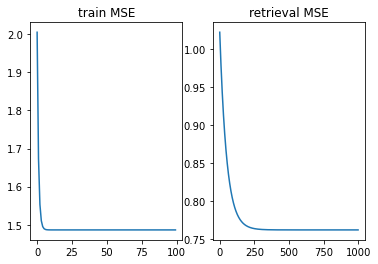

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_mses_im)
ax[0].set_title('train MSE')
ax[1].plot(retrieval_mses_im)
ax[1].set_title('retrieval MSE')
plt.show()

# hierarchical PCN

In [7]:
nodes = [2, 2]
inference_lr = 0.1 # could be more fine-tuned for each model
training_lr = 1e-4 # could be more fine-tuned for each model
training_iters = 150
inference_iters = 100
hPCN = HierarchicalPCN(nodes, 'Linear', inference_lr, init_std=0.).to(device)
optimizer_h = torch.optim.SGD(hPCN.parameters(), lr=training_lr)

train_mses_h = []
for i in range(training_iters):
    if i % 10 == 0:
        print('Epoch', i)
    for batch_idx in range(0, sample_size, batch_size):
        data = X[batch_idx:batch_idx+batch_size]
        optimizer_h.zero_grad()
        hPCN.train_pc_generative(data, inference_iters, update_mask)
        optimizer_h.step()
    # train_mses_h.append(np.sum([torch.mean(hPCN.errs[l]**2).cpu().detach().numpy() for l in range(len(nodes))]))
    train_mses_h.append(torch.mean(hPCN.errs[-1]**2).cpu().detach().numpy())
    

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140


In [8]:
inference_iters = 1000
with torch.no_grad():
    hPCN.initialize()
    hPCN.set_nodes(X_c)
    retrieval_mses_h = []
    for itr in range(inference_iters):
        hPCN.update_val_nodes(update_mask, recon=True)
        X_recon_h = hPCN.val_nodes[-1]
        retrieval_mse = torch.mean((X_recon_h - X)**2)
        retrieval_mses_h.append(retrieval_mse.cpu().detach().numpy())
        if itr % (inference_iters // 10) == 0:
            print(f'iter {itr}, retrieval mse {retrieval_mse}')

iter 0, retrieval mse 1.0273407697677612
iter 100, retrieval mse 0.8821150064468384
iter 200, retrieval mse 0.8382666110992432
iter 300, retrieval mse 0.8208135962486267
iter 400, retrieval mse 0.8132728338241577
iter 500, retrieval mse 0.809852123260498
iter 600, retrieval mse 0.808259129524231
iter 700, retrieval mse 0.8075075745582581
iter 800, retrieval mse 0.807150661945343
iter 900, retrieval mse 0.8069804906845093


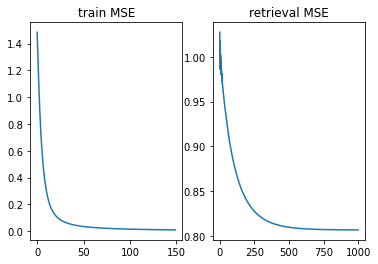

In [9]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_mses_h)
ax[0].set_title('train MSE')
ax[1].plot(retrieval_mses_h)
ax[1].set_title('retrieval MSE')
plt.show()

# Visualization

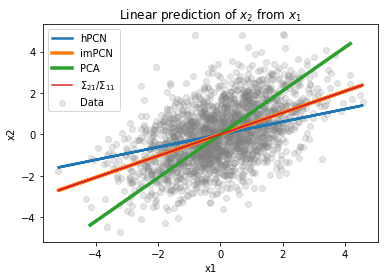

In [14]:
from sklearn.decomposition import PCA
X_ = X.cpu().detach().numpy()

# PCA
pca = PCA(n_components=2).fit(X_)
comp = pca.components_[0] * pca.explained_variance_[0] * 2

# models
X_recon_h_ = X_recon_h.cpu().detach().numpy()
X_recon_im_ = X_recon_im.cpu().detach().numpy()
# sample covariance matrix
ML_cov = np.cov(X.T)
# plot the learned linear retrievals
plt.figure()
plt.scatter(X_[:,0], X_[:,1], alpha=0.2, color='gray', label='Data')
plt.plot(X_[:,0], X_recon_h_[:,1], label='hPCN', lw=2.5)
plt.plot(X_[:,0], X_recon_im_[:,1], label='imPCN', lw=3.5)
plt.plot([-comp[0], comp[0]], [-comp[1], comp[1]], label='PCA', lw=3.5)
plt.plot(X_[:,0], (ML_cov[1,0]/ML_cov[0,0])*X_[:,0], label=r'$\Sigma_{21}/\Sigma_{11}$')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title(r'Linear prediction of $x_2$ from $x_1$')
plt.savefig('../figs/pca-pcn.jpg', dpi=400)
plt.show()

What's the linear retrieval equation for hPCN?

In [35]:
W = hPCN.layers[0].weight
torch.matmul(W.t(), W)

tensor([[14.7366,  6.3437],
        [ 6.3437,  2.7308]], grad_fn=<MmBackward>)

In [27]:
hPCN.memory

Parameter containing:
tensor([-3.0191, -1.2238], requires_grad=True)